# Titanic Survival Prediction

In [654]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Importing dataset

In [591]:
df = pd.read_csv("Titanic-Dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [592]:
df.shape

(891, 12)

In [593]:
# No. of Duplicate entries
df.duplicated().sum()

0

In [594]:
df = df.drop_duplicates()

In [595]:
df.shape # 891-16 = 875

(891, 12)

## Exploratory Data Analysis (EDA)

In [596]:
# PassengerId is just a representation of index -- deleting it
df.drop("PassengerId", axis = 1, inplace=True)

In [597]:
# Possible values for "Survived"
df['Survived'].unique()   # Binary attribute - 0 (not survived) / 1 (survived)

array([0, 1], dtype=int64)

In [598]:
# Possible values for "Survived"
df['Pclass'].unique()   # 1/2/3

array([3, 1, 2], dtype=int64)

In [599]:
# Name of the person has nothing to do with survival prediction
# Ofcourse gender can, but it's given separately as "Sex"
df.drop("Name", inplace=True, axis=1)

In [600]:
# Sex Attribute
df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [601]:
# Converting into 1/0
# isFemale = 1 if female else 0
df['isFemale'] = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)
df.drop('Sex', axis=1, inplace=True)

In [602]:
# Possible values for SibSp
# No of siblings/spouse of the passenger aboard the titanic.
df['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [603]:
# Possible values of Parch
# No of parents/children of the passenger aboard the titanic
df['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [604]:
# After correlation analysis, SibSp and Parch doesn't seem to have much correlation. So, removing from the dataset
df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

## Ticket: Attribute Analysis

The attribute "Ticket" is a special case here. It consists of alphanumeric information which has to be splitted and decoded to bring good insights out of it. Having the ticket value as it is doesn't give any significant information. If the decoding information is available, one has to do preprocessing according to those conditions. But since the decoding information is absent, let's do some ordinary preprocessing to make most use of  the given information.

<Axes: xlabel='count'>

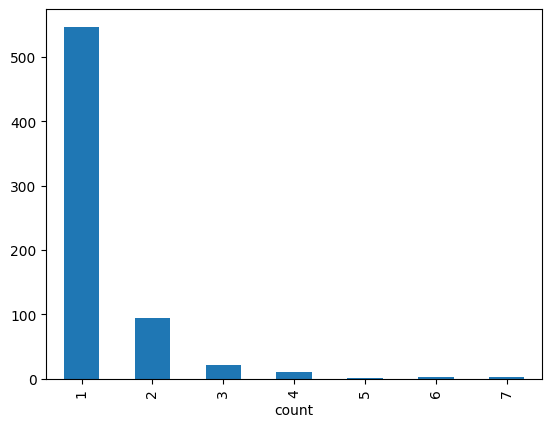

In [605]:
# Ticket is a complex data
# This needs special care
df_head = pd.DataFrame(df['Ticket'].value_counts()).groupby('count').size()
df_head.plot(kind='bar')

Majority tickets are unique. But some tickets are shared (i.e. same ticket is used by multiple passengers.) <br>
Possible explanation could be that the ticket is a "group ticket" - one ticket for one family

In [606]:
df['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [607]:
# Exploring the data similarity when the data is same
'''
for i in df['Ticket'].value_counts().index:
    print(i)
    print(df[df['Ticket'] == i].drop('Ticket',axis=1).head())
    print()
'''
pass

VISUAL HYPHOTHESIS: <br>
Visually, we can notice that the first numeric value of the ticket represent the pClass --> NOT ALWAYS TRUE BUT IT HAPPENS IN MOST CASES<br>
These assumptions were required because the decoding information is not clear. <br>
So, with this observation in mind, let's split each ticket element.

In [608]:
# Possible length of splitted elements of ticket - 1,2,3
length = []
for ticket in df['Ticket']:
    length.append(len(ticket.split()))
set(length)

{1, 2, 3}

<br><br>
**Some samples for "Ticket"**

A/5 21171 <br>
PC 17599 <br>
STON/O2. 3101282 <br>
113803 <br>
C.A. 24579 <br>
A./5. 2152 <br>
S.C./A.4. 23567<br>
S.O.C. 14879<br>
SOTON/OQ 392086<br>
STON/O 2. 3101294<br>


**Devising the ticket handling technique:**
  - replacing '/' with ''
  - replacing '.' with ''
  - split with ' '
      - for each ticket, the resulting list can contain 1, 2 or 3 elements.
      - if ticket starts with an alphabet, then alphabetical prefix is present else not present <br><br>


      Let the variable be ticket1, ticket2, ticket3
       - if only one element present: keep it in ticket3 <br>
       - if two elements are present: keep it in ticket1 and ticket3 respectively  (because starting number of 2nd element seem to be the pClass) <br>
       - if three elements present: keep it in ticket1, ticket2 and ticket3 respectively (because starting number of the 3rd element seem to be pClass) <br>

In [609]:
# Splitting "ticket" according to the devised technique
ticket_prefix = []
ticket_temp = []
ticket_number = []
for ticket in df['Ticket']:
    ticket = ticket.replace('LINE','3') # Reason1: LINE will give error; Reason2: First no. represents pClass -> here 3
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    parts = ticket.split(' ')

        
    part1 = None    
    part2 = None
    part3 = None

    
    if len(parts)==1:
        part3 = parts[0]
        
    elif len(parts) ==2:
        part1 = parts[0]
        part3 = parts[1]

    else:
        part1 = parts[0]
        part2 = parts[1]
        part3 = parts[2]
        
    ticket_prefix.append(part1)
    ticket_temp.append(part2)
    ticket_number.append(part3)

df['Ticket1'] = ticket_prefix
df['Ticket2'] = ticket_temp
df['Ticket3'] = ticket_number

df = df.fillna(np.nan)

In [610]:
df.drop('Ticket', axis=1, inplace=True)

In [611]:
df.head()

,Survived,Pclass,Age,Fare,Cabin,Embarked,isFemale,Ticket1,Ticket2,Ticket3
0,0,3,22.0,7.2500,NaN,S,0,A5,NaN,21171
1,1,1,38.0,71.2833,C85,C,1,PC,NaN,17599
2,1,3,26.0,7.9250,NaN,S,1,STONO2,NaN,3101282
3,1,1,35.0,53.1000,C123,S,1,NaN,NaN,113803
4,0,3,35.0,8.0500,NaN,S,0,NaN,NaN,373450


But now, the value of ticket1 is categorical. We have to convert it into integer using LabelEncoder()

In [612]:
ticket_encoder = LabelEncoder()
df['Ticket1'] = ticket_encoder.fit_transform(df['Ticket1'])

ticket2_encoder = LabelEncoder()
df['Ticket2'] = ticket2_encoder.fit_transform(df['Ticket2'])

In [613]:
ticket_encoder.classes_

array(['A4', 'A5', 'AS', 'C', 'CA', 'CASOTON', 'FC', 'FCC', 'Fa', 'PC',
       'PP', 'PPP', 'SC', 'SCA4', 'SCAH', 'SCOW', 'SCPARIS', 'SCParis',
       'SOC', 'SOP', 'SOPP', 'SOTONO2', 'SOTONOQ', 'SP', 'STONO',
       'STONO2', 'SWPP', 'WC', 'WEP', nan], dtype=object)

In [614]:
ticket_encoder.inverse_transform([0,1,2,3,4,5])

array(['A4', 'A5', 'AS', 'C', 'CA', 'CASOTON'], dtype=object)

## Analysing the other attributes

In [615]:
# Cabin has lot of null values - so better be removed
len(df[df['Cabin'].notnull() == False])

687

In [616]:
df.drop('Cabin', inplace=True, axis=1)

In [617]:
# Possible values for embarked
df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

Port of Embarkation: <br>
C = Cherbourg, Q = Queenstown, S = Southampton

In [618]:
# No of null entries
len(df[df['Embarked'].notnull() == False])

2

Since there are just two null entries in the attribute "Embarked", we are not removing those entries. <br>
But the values must be converted to some integral entries. We can do it using LabelEncoder() <br>

In [619]:
encoder = LabelEncoder()
df['Embarked'] = encoder.fit_transform(df['Embarked'])

In [620]:
encoder.classes_

array(['C', 'Q', 'S', nan], dtype=object)

In [621]:
encoder.inverse_transform([0,1,2,3])

array(['C', 'Q', 'S', nan], dtype=object)

So now, <br>
0 -> C -> Cherbourg <br>
1 -> Q -> Queenstown <br>
2 -> S -> Southampton <br>
3 -> NaN -> Null entry

## Handling the missing values

In [622]:
for col in df.columns:
    print(col,df[col].isnull().sum())

Survived 0
Pclass 0
Age 177
Fare 0
Embarked 0
isFemale 0
Ticket1 0
Ticket2 0
Ticket3 0


<br>
So, we have to handle the missing values of age. <br>
Filling with 0 is not a good choice. <br>
Filling with mean or median can be done <br>
We can create a model to predict the age, given te criterion. But here the given features doesn't seem to give any clue about age. <br>

So, choosing to fill median throughout. Because mean is sensitive to outliers. <br>

In [623]:
df['Age'] = df['Age'].fillna(df['Age'].median())

In [624]:
df['Age'].isnull().sum()

0

## Correlation analysis on Preprocessed Dataset 

According to our hypothesis, the first value in the ticket3 and pClass must be correlated

In [625]:
firstNum = []
for i in range(len(df['Ticket3'])):
    firstNum.append(df['Ticket3'][i][0])
df['firstNum'] = firstNum

In [626]:
df.head()

,Survived,Pclass,Age,Fare,Embarked,isFemale,Ticket1,Ticket2,Ticket3,firstNum
0,0,3,22.0,7.2500,2,0,1,2,21171,2
1,1,1,38.0,71.2833,0,1,9,2,17599,1
2,1,3,26.0,7.9250,2,1,25,2,3101282,3
3,1,1,35.0,53.1000,2,1,29,2,113803,1
4,0,3,35.0,8.0500,2,0,29,2,373450,3


<Axes: >

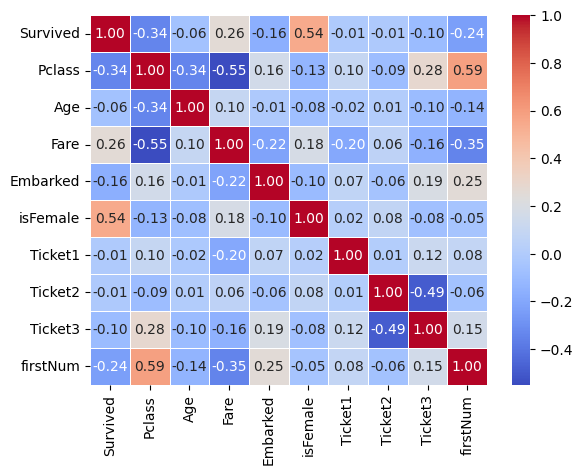

In [627]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

In [628]:
dicti = {};
for col in df.columns:
    new_df = pd.DataFrame(df.corr()[col].drop(col))
    # print(new_df[col])
    # print(new_df.columns)
    for sub,val in zip(new_df.index, new_df[col]):
        # print(col, sub,val)
        if val not in dicti:
            dicti[val] = [(col,sub)]
        elif (sub,col) not in dicti[val]:
            dicti[val].append((col,sub))

# Attribute Pairs sorted in descending order based on correlation
# Top ten correlations
new_dicti = {key:dicti[key] for key in sorted(dicti.keys(), key=lambda x: abs(x), reverse=True)[:10]}
new_dicti

{0.585956125501699: [('Pclass', 'firstNum')],
 -0.5494996199439076: [('Pclass', 'Fare')],
 0.5433513806577549: [('Survived', 'isFemale')],
 -0.4923361415888253: [('Ticket2', 'Ticket3')],
 -0.3471837997573859: [('Fare', 'firstNum')],
 -0.33989832839258594: [('Pclass', 'Age')],
 -0.33848103596101514: [('Survived', 'Pclass')],
 0.2840160689582513: [('Pclass', 'Ticket3')],
 0.2573065223849626: [('Survived', 'Fare')],
 0.252277557471508: [('Embarked', 'firstNum')]}

<br>Highest correlation between pClass and FirstNum  -  this proves our hypothesis

**Significant Insights from Correlation Analysis:** <br>
 - PClass and Fare are correlated (which is obvious)
 - Gender and survival possibility are correlated
 - pClass and survival possibility are correlated

## Modeling the dataset

Here, the objective of this problem is to predict whether a person from titanic will survive or not. <br>
So, this is a classification problem. So, we have to model this dataset using classification models.

In [629]:
df.head()

,Survived,Pclass,Age,Fare,Embarked,isFemale,Ticket1,Ticket2,Ticket3,firstNum
0,0,3,22.0,7.2500,2,0,1,2,21171,2
1,1,1,38.0,71.2833,0,1,9,2,17599,1
2,1,3,26.0,7.9250,2,1,25,2,3101282,3
3,1,1,35.0,53.1000,2,1,29,2,113803,1
4,0,3,35.0,8.0500,2,0,29,2,373450,3


In [630]:
# Attributes and target split
X = df.drop('Survived', axis=1)
y = df['Survived']

In [631]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [632]:
# Logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6536312849162011

In [633]:
# KFold for Logistic Regression
model = LogisticRegression()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score_logistic = cross_val_score(model, X, y, cv=kfold)
print(cv_score_logistic.mean())

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

0.6857824367585211


In [634]:
# KNN
model = KNeighborsClassifier(5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6759776536312849

In [635]:
# KFold for KNN
model = KNeighborsClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score_KNN = cross_val_score(model, X, y, cv=kfold)
cv_score_KNN.mean()

0.6868809239846839

In [636]:
# SVM
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.5865921787709497

In [637]:
# KFold for SVM
model = SVC()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score_SVM = cross_val_score(model, X, y, cv=kfold)
cv_score_SVM.mean()

0.616194840248572

In [638]:
# Naive Bayes
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6424581005586593

In [639]:
# KFold for NaiveBayes
model = GaussianNB()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score_NB = cross_val_score(model, X, y, cv=kfold)
cv_score_NB.mean()

0.6644466762915071

In [684]:
# Decision Tree
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_test)
accuracy_score(y_pred, y_test)

0.7932960893854749

In [685]:
# KFold for decision tree
model = DecisionTreeClassifier()
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
cv_score_DT = cross_val_score(model, X, y, cv=kfold)
cv_score_DT.mean()

0.7845019145063085

In [686]:
# Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8435754189944135

In [687]:
# KFold for Random forest
model = RandomForestClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score_RF = cross_val_score(model, X, y, cv=kfold)
cv_score_RF.mean()

0.8372481325717155

In [688]:
# AdaBoost 
model = AdaBoostClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.8212290502793296

In [689]:
# KFold for AdaBoost
model = AdaBoostClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score_AB = cross_val_score(model, X, y, cv=kfold)
cv_score_AB.mean()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is depr

0.8024480572468772

In [690]:
# LDA
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7877094972067039

In [691]:
# KFold for LDA
model = LinearDiscriminantAnalysis()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score_LDA = cross_val_score(model, X, y, cv=kfold)
cv_score_LDA.mean()

0.7856317870817903

In [692]:
# Gradient Booster
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8268156424581006

In [693]:
# KFold for GradBoost
model = GradientBoostingClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score_GB = cross_val_score(model, X, y, cv=kfold)
cv_score_GB.mean()

0.8372732408511705

## Model Evaluation Summary

In [694]:
scores = pd.DataFrame({
    'Model': ['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machines', 'Naive Bayes', 
     'Decision Tree', 'Random Forest', 'AdaBoost', 'Linear Discriminant Analysis', 'GradBoost'], 

    'Score': [cv_score_logistic.mean(), cv_score_KNN.mean(), cv_score_SVM.mean(), cv_score_NB.mean(), 
              cv_score_DT.mean(), cv_score_RF.mean(), cv_score_AB.mean(), cv_score_LDA.mean(), cv_score_GB.mean()]})

In [695]:
scores.sort_values(by=['Score'], ascending=[False]).reset_index().drop('index', axis=1)

,Model,Score
0,GradBoost,0.837273
1,Random Forest,0.837248
2,AdaBoost,0.802448
3,Linear Discriminant Analysis,0.785632
4,Decision Tree,0.784502
5,K-Nearest Neighbors,0.686881
6,Logistic Regression,0.685782
7,Naive Bayes,0.664447
8,Support Vector Machines,0.616195


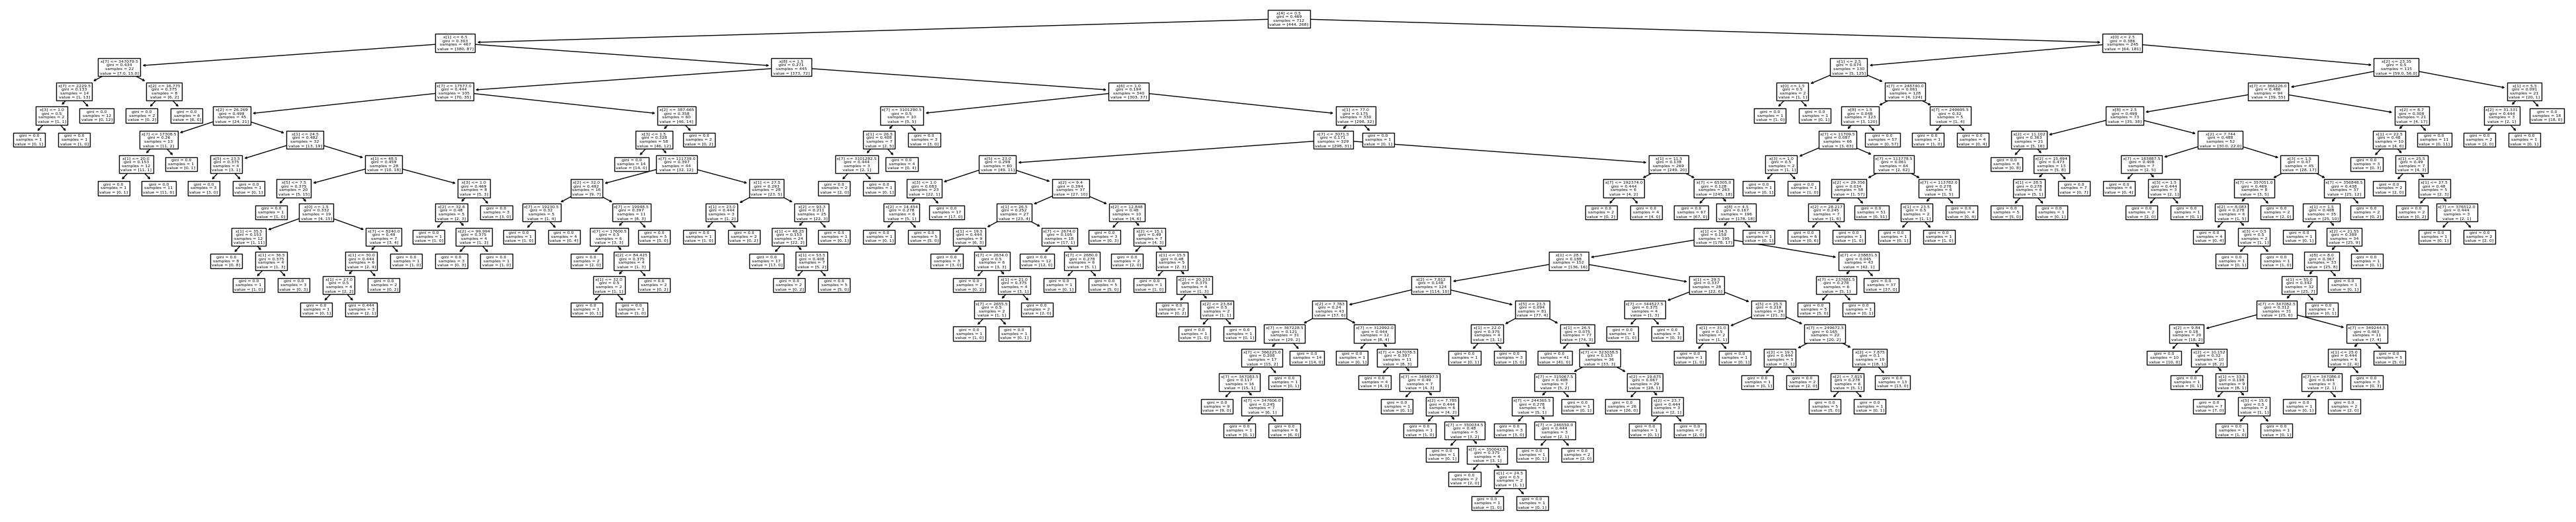

In [708]:
# Decision Tree Visualization
plt.figure(figsize=(50,10))
plot_tree(model_dt)
plt.show()